NOTE: DO NOT CLEAR OUTPUT AS IT CONTAINS WHAT WE DID THROUGHOUT THE PROCESS.
At first, for starting building out Mask Detector using PyTorch, we need to import the needed files. We do so below.

In [0]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy
from torch.utils.data import DataLoader
from torchvision import transforms as tt

In [0]:
import fastai
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

At first, we need to mount our Google Drive so that we can use our Masked Dataset there for training our model. We run the following command:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In the next 3 cells, we choose the transformations that will be necessary for data augmentation. This will prevent overfitting and help us increase our dataset. Then we make the dataset by using the ImageFolder() utility function. The labels are the subdirectories of the folders.

In [0]:
data_dir = 'gdrive/My Drive/Masked Dataset p1/'

In [0]:
train_tfms = tt.Compose([
                         tt.Resize((256,256)),
                         tt.RandomCrop(256, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(), 
                         tt.ColorJitter(),
                         tt.ToTensor()])
valid_tfms = tt.Compose([tt.Resize((256,256)),tt.ToTensor()])

In [0]:
train_ds = torchvision.datasets.ImageFolder(data_dir+'/Trainset', train_tfms)
valid_ds = torchvision.datasets.ImageFolder(data_dir+'/ValidationSet', valid_tfms)

We have 9k images for training, 4.5k masked images and 4.5k unmasked images. We have 1k images for validation (which is also our test set as we 10k seemed less for me to make a seperate test set) out of which, 500 are masked, 500 unmasked. This can we seen below.

In [7]:
print(train_ds)

Dataset ImageFolder
    Number of datapoints: 9000
    Root location: gdrive/My Drive/Masked Dataset p1//Trainset
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               RandomCrop(size=(256, 256), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               ToTensor()
           )


In [8]:
print(valid_ds)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: gdrive/My Drive/Masked Dataset p1//ValidationSet
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


As Colab provides us a RAM of 12GB, to utilize it maximum, I've set the batch size as 50, and as the images are of size 256*256, 11GB+ RAM is used.

In [0]:
batch_size = 25

Then we use the dataloaders which will convert the training set into batches of data which will make computation faster. We keep shuffle=true as data needs to be randomised because our sets are ordered. num_workers assigns the number of cores on GPU. pin_memory avoids memory upload overhead.

In [0]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)

Before continuing to make our model, let's view a batch of data using make_grid functionality in torchvision.

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        break 

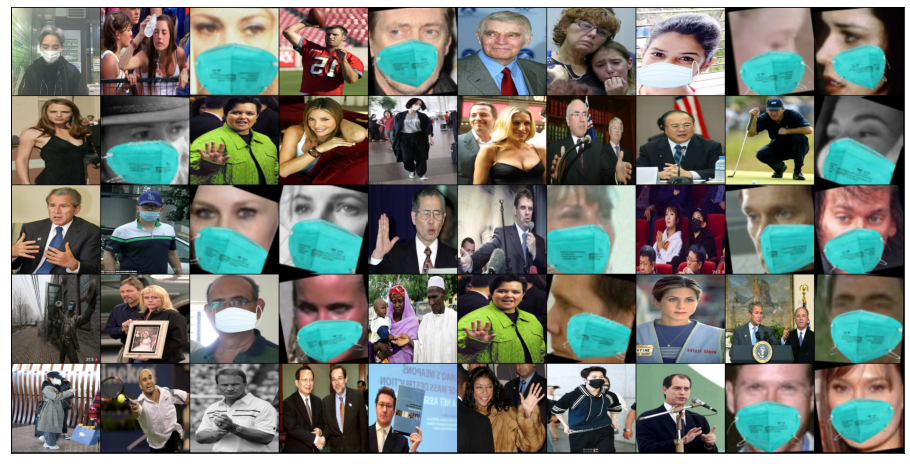

In [0]:
show_batch(train_dl)

In [0]:
import torch.nn.functional as F

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Below, we see that the 2 classes (due to our directory structure)                                                                                                                                                                                                                              

In [15]:
class_names = train_ds.classes
print(class_names)

['Masked', 'Unmasked']


Below, we see the size of our training set and validation set. 9k and 1k, respectively.

In [16]:
dataset_sizes = [len(train_ds),len(valid_ds)]
dataset_sizes

[9000, 1000]

Below is the VGG architectures all in one code, thanks to Aladdin Persson for helping me. (https://www.youtube.com/channel/UCkzW5JSFwvKRjXABI-UTAkQ)

In [0]:
VGG_types = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG19'])
        
        self.fcs = nn.Sequential(
            nn.Linear(512*8*8, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
            )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == int:
                out_channels = x
                
                layers += [nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
                
        return nn.Sequential(*layers)

In [0]:
model=VGG_net(3,2)

Now we see the shape of our first batch of images. 
It is [50,3,256,256]. Here 50 stands for number of images in 1 batch, 3 stands for the 3 colour channels (R,G,B), and 256*256 is the image size. Output is of the form [50,2] showing that for each of the 50 images, we get 2 outputs, either masked or unmasked.

In [19]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([25, 3, 256, 256])
out.shape: torch.Size([25, 2])
out[0]: tensor([0.7642, 0.7430], grad_fn=<SelectBackward>)


Now we use the functionalities of fastai to combine our train dataloader and validation dataloader and also use Learner utility function to trace the reduction in loss for different epochs. We're using the inbuilt cross_entropy function as our loss function.

In [0]:
data = DataBunch(train_dl, valid_dl)
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

Now we plot the loss with respect to learning rate to find the best learning rate and train our model using it.

In [22]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


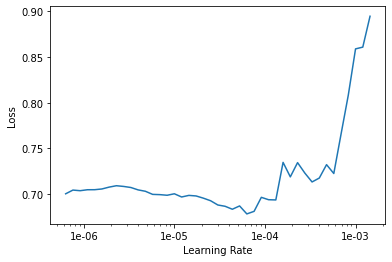

In [23]:
learner.recorder.plot()

As 10^-4 has the fastest reduction in loss, we choose it and run it for 20 epochs.

In [24]:
learner.fit_one_cycle(5, 2e-4, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.280266,1.538328,0.507000,10:00
1,0.233925,0.518031,0.794000,08:40
2,0.215065,0.619003,0.768000,08:41
3,0.081694,0.339508,0.888000,08:47
4,0.064335,0.254612,0.908000,08:48


In [25]:
learner.fit_one_cycle(1, 1e-4, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.086756,0.215414,0.924000,08:47


In [26]:
learner.fit_one_cycle(1, 1e-5, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.055719,0.266049,0.910000,08:44


Finally, we save the model parameters for future use.

In [0]:
model_save_name='weights2.pt'
path=F"/content/gdrive/My Drive/ClassifierWithPyTorch/{model_save_name}"
torch.save(model.state_dict(),path)

In [0]:
model_save_name='weights2.pt'
path=F"/content/gdrive/My Drive/ClassifierWithPyTorch/{model_save_name}"
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()

In [0]:
def maskDetection(img):
    img=img.resize((256,256))
    img = tt.ToTensor()(img).unsqueeze_(0)
    list=F.softmax(model(img),dim=1)
    print(list[0][0],list[0][1])
    if(list[0][0].item()>list[0][1].item()):
      return "Masked"
    return "Unmasked"

Now let's test our model on some images from the internet, I will choose Lionel Messi to be the first because he is the greatest of all time. Let's test our model on his face:

In [0]:
import PIL
from PIL import Image
img  = Image.open('/content/gdrive/My Drive/ClassifierWithPyTorch/TestFaces/messi.jpg') 

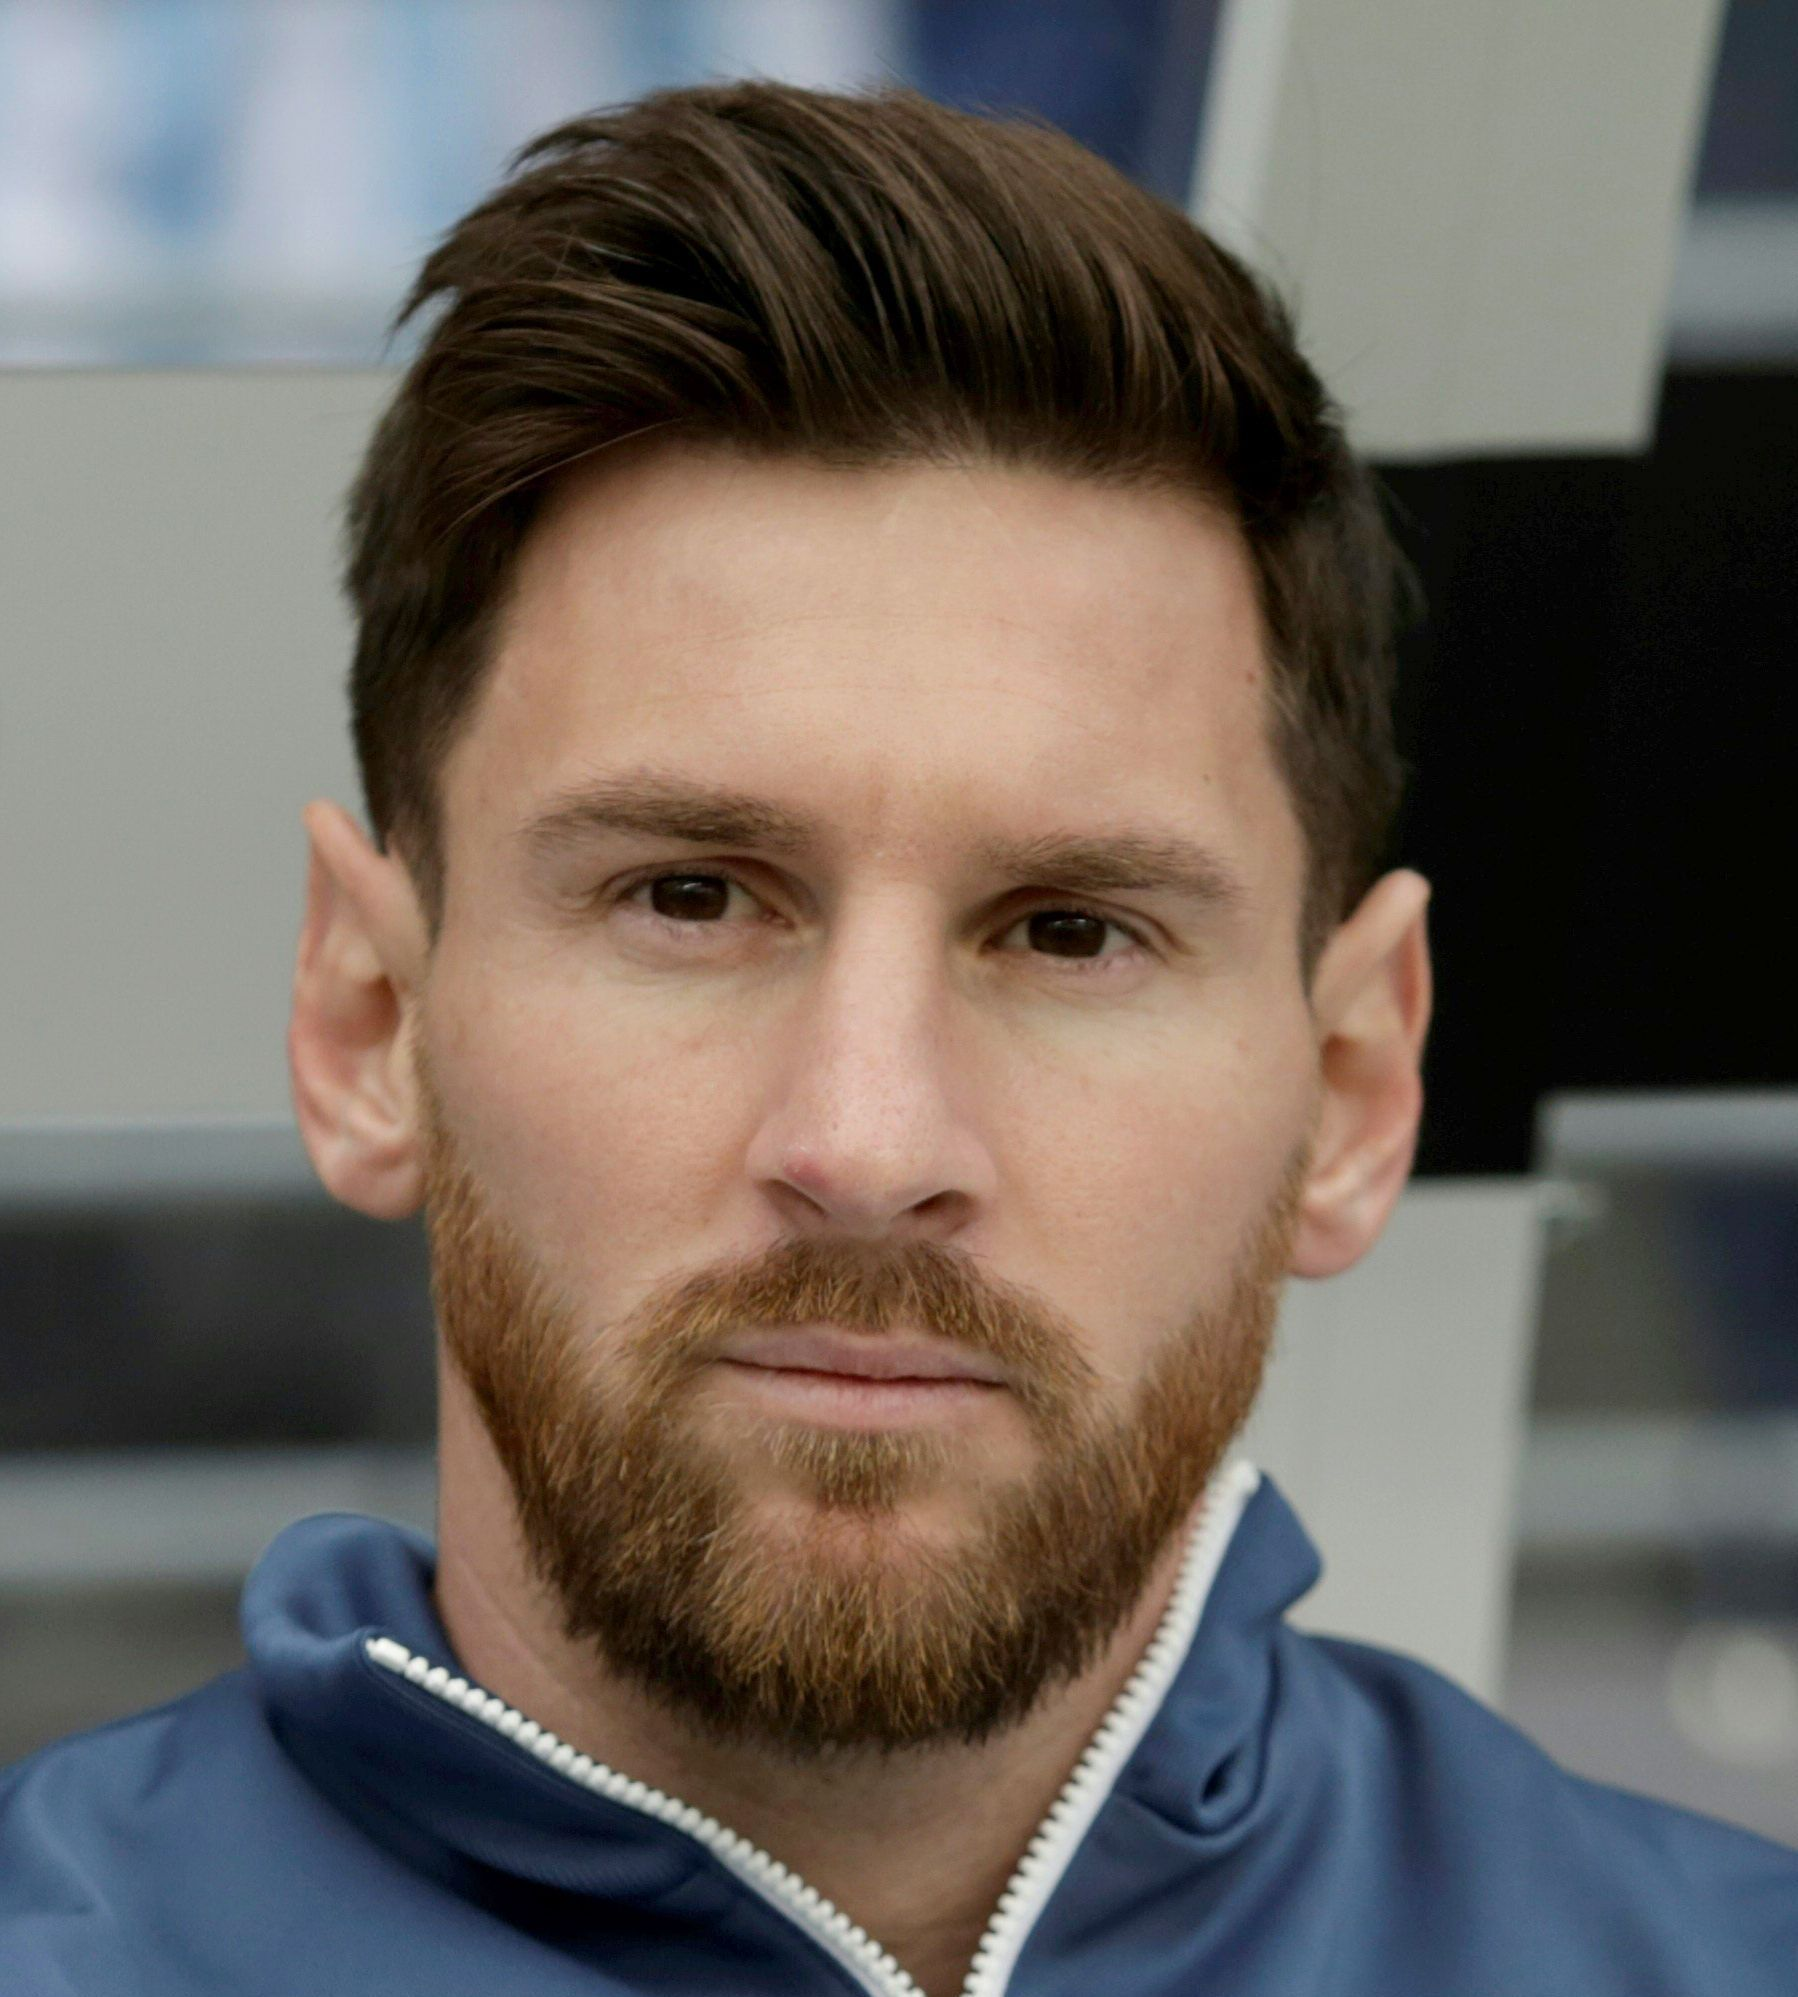

In [18]:
from IPython.display import Image as image
image('/content/gdrive/My Drive/ClassifierWithPyTorch/TestFaces/messi.jpg')

In [38]:
maskDetection(img)

tensor(0.0018, grad_fn=<SelectBackward>) tensor(0.9982, grad_fn=<SelectBackward>)


'Unmasked'

As we can see, Messi is unmasked and our output is right. Now let's try it on a person with mask on.

In [0]:
 img  = Image.open('/content/gdrive/My Drive/ClassifierWithPyTorch/TestFaces/maskedWoman.jpg') 

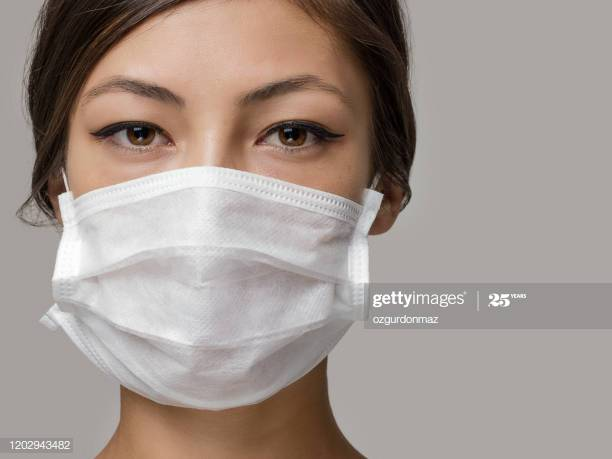

In [35]:
image('/content/gdrive/My Drive/ClassifierWithPyTorch/TestFaces/maskedWoman.jpg')

In [36]:
maskDetection(img)

tensor(0.9941, grad_fn=<SelectBackward>) tensor(0.0059, grad_fn=<SelectBackward>)


'Masked'

As we can see, the woman is masked and so is our output.
Let's not discriminate, here's a pic of Ronaldo's face.

In [0]:
 img  = Image.open('/content/gdrive/My Drive/ClassifierWithPyTorch/TestFaces/ronaldo.jpg') 

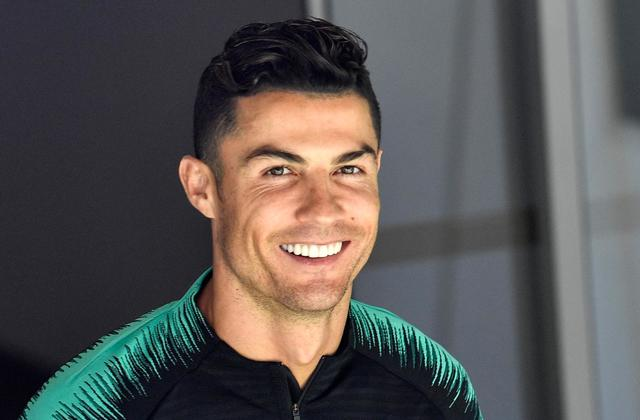

In [40]:
image('/content/gdrive/My Drive/ClassifierWithPyTorch/TestFaces/ronaldo.jpg')

In [41]:
maskDetection(img)

tensor(2.7641e-06, grad_fn=<SelectBackward>) tensor(1.0000, grad_fn=<SelectBackward>)


'Unmasked'

Finally, a pic of masked me. (also an evidence that I am, indeed, very scared of the pandemic)

In [0]:
 img  = Image.open('/content/gdrive/My Drive/ClassifierWithPyTorch/TestFaces/saurabh.jpg') 

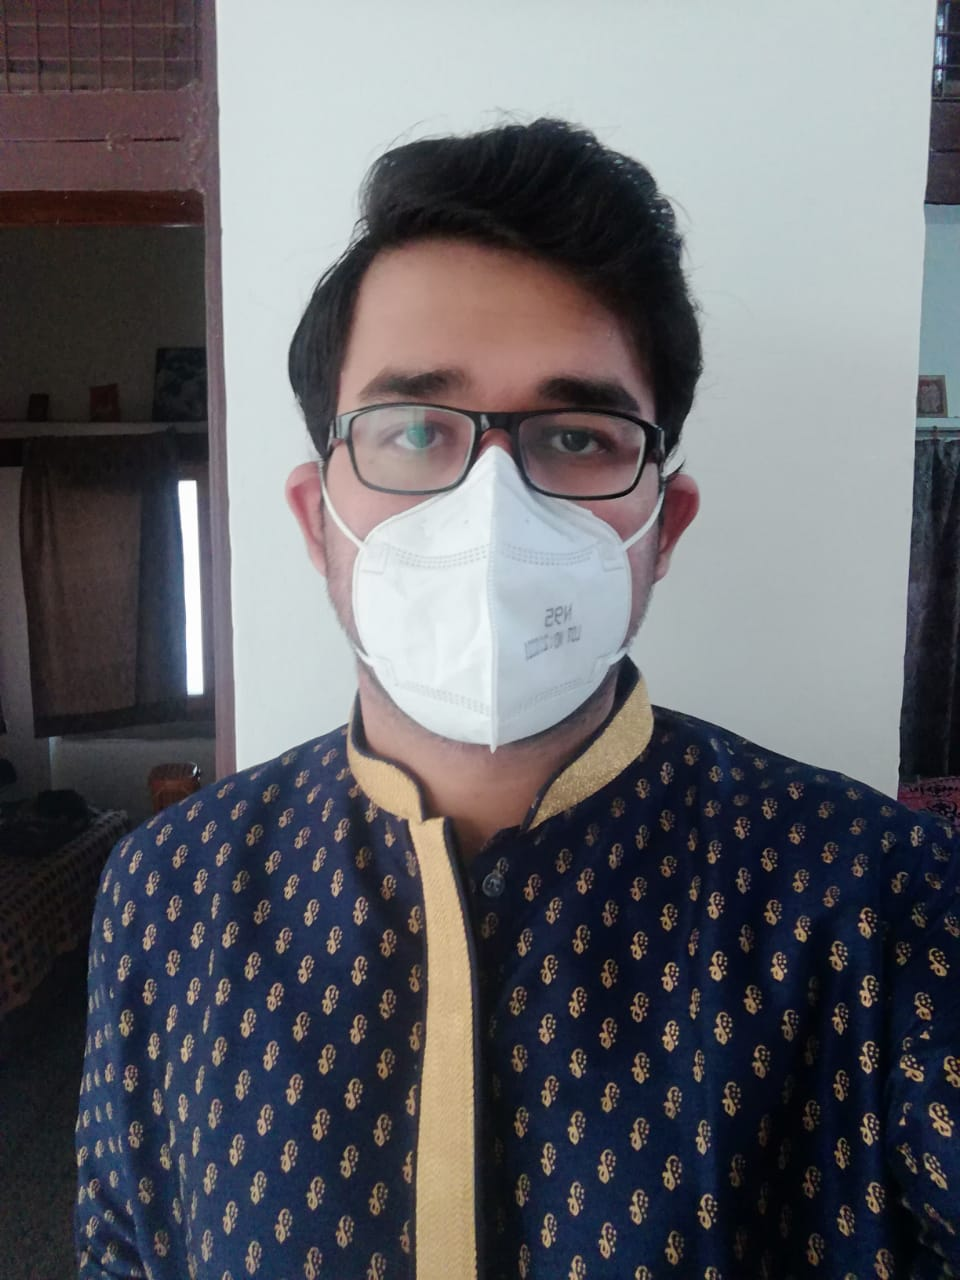

In [46]:
image('/content/gdrive/My Drive/ClassifierWithPyTorch/TestFaces/saurabh.jpg')

In [47]:
maskDetection(img)

tensor(0.9942, grad_fn=<SelectBackward>) tensor(0.0058, grad_fn=<SelectBackward>)


'Masked'

I am masked and so is the output. Looks like our model is doing pretty well, now it is time to use openCV and make realtime predictions. Kindly find the python code in the directory.